In [157]:
from numpy import dtype
from kdg import kdf, kdn, kdcnn
from kdg.utils import get_ece, plot_reliability
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Activation, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization
from tensorflow.keras import activations
from tensorflow.keras import backend as bknd
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os 
import numpy as np
import pickle
import openml
from sklearn.metrics import cohen_kappa_score
from kdg.utils import get_ece
import numpy as np
from scipy.stats import multivariate_normal
import warnings
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
import random

In [151]:
def getLeNet(input_shape, num_classes):
    model = keras.Sequential()
    inputs = Input(shape=input_shape)
    x = Conv2D(6, (3,3), kernel_initializer='he_uniform')(inputs)
    x = Activation('relu')(x)
    x = AveragePooling2D()(x)
    x = Conv2D(16, (3,3), kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D((2,2))(x)

    x = Flatten()(x)
    x = Dense(120, kernel_initializer='he_uniform')(x)
    x = Activation('relu')(x)
    x = Dense(84, kernel_initializer='he_uniform')(x)
    x = Activation('relu')(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model
    

In [152]:
### Hyperparameters ###
subtract_pixel_mean = True
normalize = False
classes_to_consider = [[0,1], [2,3],
                       [4,5], [6,7],
                       [8,9]]
seeds = [0,100,200,300,400]

compile_kwargs = {
        "loss": "binary_crossentropy",
        "optimizer": keras.optimizers.Adam(3e-4),
    }
callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10, verbose=True)
fit_kwargs = {
        "epochs": 100,
        "batch_size": 32,
        "verbose": False,
        "callbacks": [callback],
    }

In [153]:
### preprocess the data ###

def get_data(classes):
    (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
    input_shape = x_train.shape[1:]

    train_idx = np.where(y_train==classes[0])[0]
    test_idx = np.where(y_test==classes[0])[0]

    for ii in classes[1:]:
        train_idx = np.concatenate((
                        train_idx,
                        np.where(y_train==ii)[0]
                    ))
        test_idx = np.concatenate((
                        test_idx,
                        np.where(y_test==ii)[0]
                    ))

    x_train, y_train = x_train[train_idx], y_train[train_idx]
    x_test, y_test = x_test[test_idx], y_test[test_idx]
    
    _, y_train = np.unique(y_train, return_inverse=True)
    _, y_test = np.unique(y_test, return_inverse=True)
    
    if normalize:
        x_train = x_train.astype('float32') / 255
        x_test = x_test.astype('float32') / 255
    else:
        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
    
    x_train_mean = np.mean(x_train, axis=0)
    if subtract_pixel_mean:
        x_train -= x_train_mean
        x_test -= x_train_mean
    return (x_train, y_train), (x_test, y_test), x_train_mean

In [155]:
### train LeNet5 ###

for task, classes in enumerate(classes_to_consider):
    (x_train, y_train), (x_test, y_test), _ = get_data(classes)
    input_shape = x_train[0].shape
    for seed in seeds:
        np.random.seed(seed)
        nn = getLeNet(input_shape, num_classes=len(np.unique(y_train)))
        nn.compile(**compile_kwargs)
        history = nn.fit(x_train, keras.utils.to_categorical(y_train), **fit_kwargs)
        
        y_pred = np.argmax(nn.predict(x_test), axis=1)
        print('Trained model with classes ', classes, ' seed ', seed)
        print('Accuracy:', np.mean(y_pred==y_test.reshape(-1)))
        nn.save('lenet_models/cifar10_model_'+str(task)+'_'+str(seed))

2023-08-05 12:21:13.939056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 49: early stopping
63/63 [==============================] - 0s 3ms/step


2023-08-05 12:23:00.764011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Trained model with classes  [0, 1]  seed  0
Accuracy: 0.909


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_0_0/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_0_0/assets
2023-08-05 12:23:01.569966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 51: early stopping
63/63 [==============================] - 0s 2ms/step


2023-08-05 12:24:51.946076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Trained model with classes  [0, 1]  seed  100
Accuracy: 0.9115


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_0_100/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_0_100/assets
2023-08-05 12:24:52.755993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 44: early stopping
63/63 [==============================] - 0s 2ms/step


2023-08-05 12:26:28.678642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Trained model with classes  [0, 1]  seed  200
Accuracy: 0.912


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_0_200/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_0_200/assets
2023-08-05 12:26:29.517766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 45: early stopping
63/63 [==============================] - 0s 3ms/step


2023-08-05 12:28:07.340798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Trained model with classes  [0, 1]  seed  300
Accuracy: 0.9305


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_0_300/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_0_300/assets
2023-08-05 12:28:08.155446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 52: early stopping
48/63 [=====================>........] - ETA: 0s

2023-08-05 12:30:00.136199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Trained model with classes  [0, 1]  seed  400
Accuracy: 0.918


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_0_400/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_0_400/assets
2023-08-05 12:30:01.524509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 77: early stopping
63/63 [==============================] - 0s 3ms/step


2023-08-05 12:32:48.562442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Trained model with classes  [2, 3]  seed  0
Accuracy: 0.7655


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_1_0/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_1_0/assets
2023-08-05 12:32:49.373073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 50: early stopping
63/63 [==============================] - 0s 2ms/step


2023-08-05 12:34:36.587178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Trained model with classes  [2, 3]  seed  100
Accuracy: 0.7535


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_1_100/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_1_100/assets
2023-08-05 12:34:37.390326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 79: early stopping
48/63 [=====================>........] - ETA: 0s

2023-08-05 12:37:26.226391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Trained model with classes  [2, 3]  seed  200
Accuracy: 0.773


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_1_200/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_1_200/assets
2023-08-05 12:37:27.052116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 76: early stopping
45/63 [====================>.........] - ETA: 0s

2023-08-05 12:40:10.938318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Trained model with classes  [2, 3]  seed  300
Accuracy: 0.771


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_1_300/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_1_300/assets
2023-08-05 12:40:11.764931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


46/63 [====================>.........] - ETA: 0s

2023-08-05 12:43:47.703348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Trained model with classes  [2, 3]  seed  400
Accuracy: 0.7695


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_1_400/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_1_400/assets
2023-08-05 12:43:48.728484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 64: early stopping
63/63 [==============================] - 0s 3ms/step


2023-08-05 12:46:05.957367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Trained model with classes  [4, 5]  seed  0
Accuracy: 0.817


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_2_0/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_2_0/assets
2023-08-05 12:46:06.765237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 53: early stopping
48/63 [=====================>........] - ETA: 0s

2023-08-05 12:48:00.659799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Trained model with classes  [4, 5]  seed  100
Accuracy: 0.8275


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_2_100/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_2_100/assets
2023-08-05 12:48:01.901820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 65: early stopping
63/63 [==============================] - 0s 3ms/step


2023-08-05 12:50:21.680550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Trained model with classes  [4, 5]  seed  200
Accuracy: 0.819


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_2_200/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_2_200/assets
2023-08-05 12:50:22.490972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 94: early stopping
63/63 [==============================] - 0s 3ms/step


2023-08-05 12:53:44.519108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Trained model with classes  [4, 5]  seed  300
Accuracy: 0.834


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_2_300/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_2_300/assets
2023-08-05 12:53:45.337210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 65: early stopping
63/63 [==============================] - 0s 3ms/step


2023-08-05 12:56:07.404420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Trained model with classes  [4, 5]  seed  400
Accuracy: 0.824


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_2_400/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_2_400/assets
2023-08-05 12:56:08.421230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 39: early stopping
46/63 [====================>.........] - ETA: 0s

2023-08-05 12:57:32.174482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Trained model with classes  [6, 7]  seed  0
Accuracy: 0.917


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_3_0/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_3_0/assets
2023-08-05 12:57:33.015957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 43: early stopping
50/63 [======================>.......] - ETA: 0s

2023-08-05 12:59:03.968390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 2ms/step
Trained model with classes  [6, 7]  seed  100
Accuracy: 0.921


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_3_100/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_3_100/assets
2023-08-05 12:59:04.769750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 58: early stopping
49/63 [======================>.......] - ETA: 0s

2023-08-05 13:01:00.075867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Trained model with classes  [6, 7]  seed  200
Accuracy: 0.925


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_3_200/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_3_200/assets
2023-08-05 13:01:01.231815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 73: early stopping
47/63 [=====================>........] - ETA: 0s

2023-08-05 13:03:26.560438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Trained model with classes  [6, 7]  seed  300
Accuracy: 0.914


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_3_300/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_3_300/assets
2023-08-05 13:03:27.357575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 51: early stopping
49/63 [======================>.......] - ETA: 0s

2023-08-05 13:05:09.236327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Trained model with classes  [6, 7]  seed  400
Accuracy: 0.919


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_3_400/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_3_400/assets
2023-08-05 13:05:10.232054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 54: early stopping
53/63 [========================>.....] - ETA: 0s

2023-08-05 13:06:57.735090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Trained model with classes  [8, 9]  seed  0
Accuracy: 0.9075


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_4_0/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_4_0/assets
2023-08-05 13:06:58.526754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 71: early stopping
49/63 [======================>.......] - ETA: 0s

2023-08-05 13:09:19.545743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Trained model with classes  [8, 9]  seed  100
Accuracy: 0.891


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_4_100/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_4_100/assets
2023-08-05 13:09:20.343165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 67: early stopping
48/63 [=====================>........] - ETA: 0s

2023-08-05 13:11:34.103427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Trained model with classes  [8, 9]  seed  200
Accuracy: 0.8935


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_4_200/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_4_200/assets
2023-08-05 13:11:34.916583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 77: early stopping
49/63 [======================>.......] - ETA: 0s

2023-08-05 13:14:07.706933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Trained model with classes  [8, 9]  seed  300
Accuracy: 0.91


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_4_300/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_4_300/assets
2023-08-05 13:14:08.511720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 59: early stopping
49/63 [======================>.......] - ETA: 0s

2023-08-05 13:16:05.557825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Trained model with classes  [8, 9]  seed  400
Accuracy: 0.901


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_4_400/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_4_400/assets


In [156]:
### load models and train kgn ###
for task, classes in enumerate(classes_to_consider):
    (x_train, y_train), (x_test, y_test), _ = get_data(classes)
    for seed in seeds:
        print('Training cifar10_model_'+str(task)+'_'+str(seed))
        nn = keras.models.load_model('lenet_models/cifar10_model_'+str(task)+'_'+str(seed))
        model_kdn = kdn(network=nn)
        model_kdn.fit(x_train, y_train, batch=10)
        model_kdn.global_bias = -1e9
        
        with open('kdn_models/cifar10_model_'+str(task)+'_'+str(seed)+'.pickle', 'wb') as f:
            pickle.dump(model_kdn, f)

Training cifar10_model_0_0


INFO:tensorflow:Assets written to: ram://27f7c601-963c-4753-874b-f792cb6880c6/assets


INFO:tensorflow:Assets written to: ram://27f7c601-963c-4753-874b-f792cb6880c6/assets


Training cifar10_model_0_100


INFO:tensorflow:Assets written to: ram://dec1be89-0665-42cf-9907-7c7fd7f46cbc/assets


INFO:tensorflow:Assets written to: ram://dec1be89-0665-42cf-9907-7c7fd7f46cbc/assets


Training cifar10_model_0_200


INFO:tensorflow:Assets written to: ram://96453b34-e7ff-470b-ad88-5f020eef3fca/assets


INFO:tensorflow:Assets written to: ram://96453b34-e7ff-470b-ad88-5f020eef3fca/assets


Training cifar10_model_0_300


INFO:tensorflow:Assets written to: ram://25ace94e-74e9-4a41-a9df-5cb3e0d05ad9/assets


INFO:tensorflow:Assets written to: ram://25ace94e-74e9-4a41-a9df-5cb3e0d05ad9/assets


Training cifar10_model_0_400


INFO:tensorflow:Assets written to: ram://8e83da3b-cf73-4927-a74a-19c1763aa1f2/assets


INFO:tensorflow:Assets written to: ram://8e83da3b-cf73-4927-a74a-19c1763aa1f2/assets


Training cifar10_model_1_0


INFO:tensorflow:Assets written to: ram://33db1ccb-93ed-4866-9825-c359c53d9204/assets


INFO:tensorflow:Assets written to: ram://33db1ccb-93ed-4866-9825-c359c53d9204/assets


Training cifar10_model_1_100


INFO:tensorflow:Assets written to: ram://2f5e079c-9253-4369-aa7a-d4c991e9e740/assets


INFO:tensorflow:Assets written to: ram://2f5e079c-9253-4369-aa7a-d4c991e9e740/assets


Training cifar10_model_1_200


INFO:tensorflow:Assets written to: ram://02a3f1a4-bcba-4c37-a9e7-b068480337c2/assets


INFO:tensorflow:Assets written to: ram://02a3f1a4-bcba-4c37-a9e7-b068480337c2/assets


Training cifar10_model_1_300


INFO:tensorflow:Assets written to: ram://ab7e55c5-84a7-4440-b5d2-015f6a90ccdf/assets


INFO:tensorflow:Assets written to: ram://ab7e55c5-84a7-4440-b5d2-015f6a90ccdf/assets


Training cifar10_model_1_400


INFO:tensorflow:Assets written to: ram://5a3bd5cd-7117-4482-be20-f18df0ce3587/assets


INFO:tensorflow:Assets written to: ram://5a3bd5cd-7117-4482-be20-f18df0ce3587/assets


Training cifar10_model_2_0


INFO:tensorflow:Assets written to: ram://7ba1bf62-0de7-4f3b-8568-5df538f6e5fd/assets


INFO:tensorflow:Assets written to: ram://7ba1bf62-0de7-4f3b-8568-5df538f6e5fd/assets


Training cifar10_model_2_100


INFO:tensorflow:Assets written to: ram://973cc294-7a5c-4322-9f0e-f1d227a4dc0a/assets


INFO:tensorflow:Assets written to: ram://973cc294-7a5c-4322-9f0e-f1d227a4dc0a/assets


Training cifar10_model_2_200


INFO:tensorflow:Assets written to: ram://a16fa23e-1585-4ba3-b842-07d4be41b23b/assets


INFO:tensorflow:Assets written to: ram://a16fa23e-1585-4ba3-b842-07d4be41b23b/assets


Training cifar10_model_2_300


INFO:tensorflow:Assets written to: ram://74f14642-6974-4697-8232-65fa77a2c0e4/assets


INFO:tensorflow:Assets written to: ram://74f14642-6974-4697-8232-65fa77a2c0e4/assets


Training cifar10_model_2_400


INFO:tensorflow:Assets written to: ram://14a4201f-610a-4410-a32c-56e303109a16/assets


INFO:tensorflow:Assets written to: ram://14a4201f-610a-4410-a32c-56e303109a16/assets


Training cifar10_model_3_0


INFO:tensorflow:Assets written to: ram://faf02df4-c8ae-4e02-9a0e-55412bdaf12d/assets


INFO:tensorflow:Assets written to: ram://faf02df4-c8ae-4e02-9a0e-55412bdaf12d/assets


Training cifar10_model_3_100


INFO:tensorflow:Assets written to: ram://c9818a6f-5bbf-4f66-ad94-5ca1d383baeb/assets


INFO:tensorflow:Assets written to: ram://c9818a6f-5bbf-4f66-ad94-5ca1d383baeb/assets


Training cifar10_model_3_200


INFO:tensorflow:Assets written to: ram://92e6ab8e-47c3-4115-9c18-113fed0670e7/assets


INFO:tensorflow:Assets written to: ram://92e6ab8e-47c3-4115-9c18-113fed0670e7/assets


Training cifar10_model_3_300


INFO:tensorflow:Assets written to: ram://26021851-62a8-4528-a84f-d913f8a07b1f/assets


INFO:tensorflow:Assets written to: ram://26021851-62a8-4528-a84f-d913f8a07b1f/assets


Training cifar10_model_3_400


INFO:tensorflow:Assets written to: ram://c7eaee21-c6a6-4854-abe2-cb03a43eba61/assets


INFO:tensorflow:Assets written to: ram://c7eaee21-c6a6-4854-abe2-cb03a43eba61/assets


Training cifar10_model_4_0


INFO:tensorflow:Assets written to: ram://87ec9631-e4d2-465b-a59a-898845a097a1/assets


INFO:tensorflow:Assets written to: ram://87ec9631-e4d2-465b-a59a-898845a097a1/assets


Training cifar10_model_4_100


INFO:tensorflow:Assets written to: ram://5d3f5afe-b54f-4190-8e22-1cfbfe7ab456/assets


INFO:tensorflow:Assets written to: ram://5d3f5afe-b54f-4190-8e22-1cfbfe7ab456/assets


Training cifar10_model_4_200


INFO:tensorflow:Assets written to: ram://e70a6457-2d65-4670-94e9-de18daff777a/assets


INFO:tensorflow:Assets written to: ram://e70a6457-2d65-4670-94e9-de18daff777a/assets


Training cifar10_model_4_300


INFO:tensorflow:Assets written to: ram://1c58355c-0dd6-4d69-921f-af54eda051ef/assets


INFO:tensorflow:Assets written to: ram://1c58355c-0dd6-4d69-921f-af54eda051ef/assets


Training cifar10_model_4_400


INFO:tensorflow:Assets written to: ram://f7937c33-4c3a-4de4-bd87-2f0998185111/assets


INFO:tensorflow:Assets written to: ram://f7937c33-4c3a-4de4-bd87-2f0998185111/assets


In [ ]:
subtract_pixel_mean = False
normalize = False

for task, classes in enumerate(classes_to_consider):
    for seed in seeds:
        print('Testing cifar10_model_'+str(task)+'_'+str(seed))
        
        np.random.seed(seed)
        result = []
        proba_kdn = {}
        proba_dn = {}
        predicted_label_kdn = {}
        predicted_label_dn = {}
        
        (_, _), (_, _), train_mean = get_data(classes)
        with open('kdn_models/cifar10_model_'+str(task)+'_'+str(seed)+'.pickle', 'rb') as f:
            model_kdn = pickle.load(f)
            
        for task_, classes_ in enumerate(classes_to_consider):
            
            if task_ == task:
                model_kdn.global_bias = -1e10
            else:
                model_kdn.global_bias = -1e7
                
            (_, _), (x_test, y_test), _ = get_data(classes_)
            x_test -= trn_mean
            
            proba_kdn['Task '+str(task_)] = model_kdn.predict_proba(x_test, distance='Geodesic')
            proba_dn['Task '+str(task_)] = model_kdn.network.predict(x_test)
            predicted_label_kdn['Task '+str(task_)] = np.argmax(proba_kdn['Task '+str(task_)], axis = 1)
            predicted_label_dn['Task '+str(task_)] = np.argmax(proba_dn['Task '+str(task_)], axis = 1)
            print('Task ', task_, ' MMC ', np.mean(np.max(proba_kdn['Task '+str(task_)], axis=1)))
            print('Task ', task_, ' MMC ', np.mean(np.max(proba_dn['Task '+str(task_)], axis=1)))
        
        
        (_, _), (x_test, y_test) = keras.datasets.cifar100.load_data()
        test_ids =  random.sample(range(0, x_test.shape[0]), 2000)
        x_test = x_test[test_ids].astype('float32')
        x_test -= trn_mean
        proba_kdn['cifar100'] = model_kdn.predict_proba(x_test, distance='Geodesic')
        proba_dn['cifar100'] = model_kdn.network.predict(x_test)
        predicted_label_kdn['cifar100'] = np.argmax(proba_kdn['cifar100'], axis = 1)
        predicted_label_dn['cifar100'] = np.argmax(proba_dn['cifar100'], axis = 1)
        print('cifar100', ' MMC ', np.mean(np.max(proba_kdn['cifar100'], axis=1)))
        print('cifar100', ' MMC ', np.mean(np.max(proba_dn['cifar100'], axis=1)))
        
        x_test = loadmat('/Users/jayantadey/svhn/train_32x32.mat')['X']
        test_ids =  random.sample(range(0, x_test.shape[3]), 2000)
        x_test = x_test[:,:,:,test_ids].astype('float32').reshape(2000,32,32,3)
        x_test -= trn_mean
        proba_kdn['svhn'] = model_kdn.predict_proba(x_test, distance='Geodesic')
        proba_dn['svhn'] = model_kdn.network.predict(x_test)
        predicted_label_kdn['svhn'] = np.argmax(proba_kdn['svhn'], axis = 1)
        predicted_label_dn['svhn'] = np.argmax(proba_dn['svhn'], axis = 1)
        print('svhn', ' MMC ', np.mean(np.max(proba_kdn['svhn'], axis=1)))
        print('svhn', ' MMC ', np.mean(np.max(proba_dn['svhn'], axis=1)))
        
        x_test = np.random.random_integers(0,high=255,size=(2000,32,32,3)).astype('float')
        x_test -= trn_mean
        proba_kdn['noise'] = model_kdn.predict_proba(x_test, distance='Geodesic')
        proba_dn['noise'] = model_kdn.network.predict(x_test)
        predicted_label_kdn['noise'] = np.argmax(proba_kdn['noise'], axis = 1)
        predicted_label_dn['noise'] = np.argmax(proba_dn['noise'], axis = 1)
        print('noise', ' MMC ', np.mean(np.max(proba_kdn['noise'], axis=1)))
        print('noise', ' MMC ', np.mean(np.max(proba_dn['noise'], axis=1)))
        
        result = [proba_kdn, proba_dn, predicted_label_kdn, predicted_label_dn]
        with open('results/model_'+str(task)+'_'+str(seed)+'.pickle', 'wb') as f:
            pickle.dump(result, f)

Testing cifar10_model_0_0
45/63 [====================>.........] - ETA: 0s

2023-08-06 10:28:33.053932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Task  0  MMC  0.9991891127820134
Task  0  MMC  0.99110293
63/63 [==============================] - 0s 2ms/step
Task  1  MMC  0.7368346296723508
Task  1  MMC  0.98095727
63/63 [==============================] - 0s 2ms/step
Task  2  MMC  0.7361423490043749
Task  2  MMC  0.98203325
63/63 [==============================] - 0s 2ms/step
Task  3  MMC  0.7123024606360723
Task  3  MMC  0.971602
63/63 [==============================] - 0s 2ms/step
Task  4  MMC  0.704356885264001
Task  4  MMC  0.980611
63/63 [==============================] - 0s 2ms/step
cifar100  MMC  0.7403559987551153
cifar100  MMC  0.97944117
63/63 [==============================] - 0s 2ms/step
svhn  MMC  0.5029994309727048
svhn  MMC  0.9824552
63/63 [==============================] - 0s 2ms/step
noise  MMC  0.5044974536174789
noise  MMC  0.9948486
Testing cifar10_model_0_100
46/63 [====================>.........] - ETA: 0s

2023-08-06 10:58:54.364016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Task  0  MMC  0.99897890123296
Task  0  MMC  0.9932534
63/63 [==============================] - 0s 2ms/step
Task  1  MMC  0.6657239409749752
Task  1  MMC  0.98026067
63/63 [==============================] - 0s 2ms/step
Task  2  MMC  0.6384808350903985
Task  2  MMC  0.9799261
63/63 [==============================] - 0s 2ms/step
Task  3  MMC  0.6174468772096005
Task  3  MMC  0.9767306
63/63 [==============================] - 0s 2ms/step
Task  4  MMC  0.6119939098131671
Task  4  MMC  0.9839808
63/63 [==============================] - 0s 2ms/step
cifar100  MMC  0.6534675092919906
cifar100  MMC  0.98133093
63/63 [==============================] - 0s 2ms/step
svhn  MMC  0.5012499954786107
svhn  MMC  0.99773306
63/63 [==============================] - 0s 2ms/step
noise  MMC  0.5002499512862915
noise  MMC  0.9989194
Testing cifar10_model_0_200
47/63 [=====================>........] - ETA: 0s

2023-08-06 11:29:09.349801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Task  0  MMC  0.9972494749243354
Task  0  MMC  0.99182063
63/63 [==============================] - 0s 2ms/step
Task  1  MMC  0.6289996031129017
Task  1  MMC  0.9788495
63/63 [==============================] - 0s 2ms/step
Task  2  MMC  0.6092498942224143
Task  2  MMC  0.97736305
63/63 [==============================] - 0s 2ms/step
Task  3  MMC  0.5587498425455724
Task  3  MMC  0.97281116
63/63 [==============================] - 0s 2ms/step
Task  4  MMC  0.5802498510088805
Task  4  MMC  0.97923726
63/63 [==============================] - 0s 2ms/step
cifar100  MMC  0.6269976908672005
cifar100  MMC  0.97732127
63/63 [==============================] - 0s 2ms/step
svhn  MMC  0.5
svhn  MMC  0.9999398
63/63 [==============================] - 0s 2ms/step
noise  MMC  0.5
noise  MMC  0.9998655
Testing cifar10_model_0_300
49/63 [======================>.......] - ETA: 0s

2023-08-06 11:59:13.046982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Task  0  MMC  0.9992499975539194
Task  0  MMC  0.9922407
63/63 [==============================] - 0s 2ms/step
Task  1  MMC  0.6254999993665249
Task  1  MMC  0.979182
63/63 [==============================] - 0s 2ms/step
Task  2  MMC  0.6012499999101253
Task  2  MMC  0.97679615
63/63 [==============================] - 0s 2ms/step
Task  3  MMC  0.576499999811314
Task  3  MMC  0.97273755
63/63 [==============================] - 0s 2ms/step
Task  4  MMC  0.590749999528964
Task  4  MMC  0.9793528
63/63 [==============================] - 0s 2ms/step
cifar100  MMC  0.6332499982299093
cifar100  MMC  0.97816867
63/63 [==============================] - 0s 2ms/step
svhn  MMC  0.5
svhn  MMC  0.99640906
63/63 [==============================] - 0s 2ms/step
noise  MMC  0.5
noise  MMC  0.99718994
Testing cifar10_model_0_400
47/63 [=====================>........] - ETA: 0s

2023-08-06 12:29:11.367375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Task  0  MMC  0.9997499992394316
Task  0  MMC  0.99036264
63/63 [==============================] - 0s 2ms/step
Task  1  MMC  0.6447499999983057
Task  1  MMC  0.98058546
63/63 [==============================] - 0s 2ms/step
Task  2  MMC  0.6039999999978974
Task  2  MMC  0.98089254
63/63 [==============================] - 0s 2ms/step
Task  3  MMC  0.5944999999980634
Task  3  MMC  0.9742293
63/63 [==============================] - 0s 2ms/step
Task  4  MMC  0.594499999995925
Task  4  MMC  0.9793269
63/63 [==============================] - 0s 2ms/step
cifar100  MMC  0.6404999999958975
cifar100  MMC  0.97774833
63/63 [==============================] - 0s 2ms/step
svhn  MMC  0.511
svhn  MMC  0.99409485
63/63 [==============================] - 0s 2ms/step
noise  MMC  0.50525
noise  MMC  0.9904693
Testing cifar10_model_1_0
47/63 [=====================>........] - ETA: 0s

2023-08-06 12:59:13.496202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Task  0  MMC  0.60975
Task  0  MMC  0.9773074
63/63 [==============================] - 0s 2ms/step
Task  1  MMC  0.99975
Task  1  MMC  0.98279727
63/63 [==============================] - 0s 2ms/step
Task  2  MMC  0.5955
Task  2  MMC  0.9825418
63/63 [==============================] - 0s 2ms/step
Task  3  MMC  0.5815
Task  3  MMC  0.97591597
63/63 [==============================] - 0s 2ms/step
Task  4  MMC  0.5565
Task  4  MMC  0.97373337
63/63 [==============================] - 0s 2ms/step
cifar100  MMC  0.604
cifar100  MMC  0.98024136
63/63 [==============================] - 0s 2ms/step
svhn  MMC  0.5515
svhn  MMC  0.96179914
63/63 [==============================] - 0s 2ms/step
noise  MMC  0.5055
noise  MMC  0.9894111
Testing cifar10_model_1_100
50/63 [======================>.......] - ETA: 0s

2023-08-06 13:28:58.352174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Task  0  MMC  0.6102474594416094
Task  0  MMC  0.9719707
63/63 [==============================] - 0s 2ms/step
Task  1  MMC  0.9994990115393059
Task  1  MMC  0.97732264
63/63 [==============================] - 0s 2ms/step
Task  2  MMC  0.6112482979775309
Task  2  MMC  0.9771111
63/63 [==============================] - 0s 2ms/step
Task  3  MMC  0.5909991114315496
Task  3  MMC  0.9736059
63/63 [==============================] - 0s 2ms/step
Task  4  MMC  0.5502498818368815
Task  4  MMC  0.97140014
63/63 [==============================] - 0s 2ms/step
cifar100  MMC  0.6072491302860137
cifar100  MMC  0.9718324
63/63 [==============================] - 0s 2ms/step
svhn  MMC  0.50025
svhn  MMC  0.98744166
63/63 [==============================] - 0s 2ms/step
noise  MMC  0.5
noise  MMC  0.99811906
Testing cifar10_model_1_200
48/63 [=====================>........] - ETA: 0s

2023-08-06 13:58:43.088317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Task  0  MMC  0.6109999527901806
Task  0  MMC  0.97767556
63/63 [==============================] - 0s 2ms/step
Task  1  MMC  0.9969998305542142
Task  1  MMC  0.9808458
63/63 [==============================] - 0s 2ms/step
Task  2  MMC  0.6132499304305246
Task  2  MMC  0.97788125
63/63 [==============================] - 0s 2ms/step
Task  3  MMC  0.5814999353262585
Task  3  MMC  0.9760177
63/63 [==============================] - 0s 2ms/step
Task  4  MMC  0.5547499757018939
Task  4  MMC  0.97383267
63/63 [==============================] - 0s 2ms/step
cifar100  MMC  0.6164999366040408
cifar100  MMC  0.9732356
63/63 [==============================] - 0s 2ms/step
svhn  MMC  0.5667499825263163
svhn  MMC  0.9649748
63/63 [==============================] - 0s 2ms/step
noise  MMC  0.5
noise  MMC  0.96911156
Testing cifar10_model_1_300
48/63 [=====================>........] - ETA: 0s

2023-08-06 14:28:28.270808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Task  0  MMC  0.6332499999199195
Task  0  MMC  0.9760191
63/63 [==============================] - 0s 2ms/step
Task  1  MMC  0.9992499997897588
Task  1  MMC  0.98255557
63/63 [==============================] - 0s 2ms/step
Task  2  MMC  0.6147499999129563
Task  2  MMC  0.97630584
63/63 [==============================] - 0s 2ms/step
Task  3  MMC  0.600999999873803
Task  3  MMC  0.9748671
63/63 [==============================] - 0s 2ms/step
Task  4  MMC  0.5712499999717986
Task  4  MMC  0.97810435
63/63 [==============================] - 0s 2ms/step
cifar100  MMC  0.6249999999298242
cifar100  MMC  0.9790848
63/63 [==============================] - 0s 2ms/step
svhn  MMC  0.5285
svhn  MMC  0.9970082
63/63 [==============================] - 0s 2ms/step
noise  MMC  0.50325
noise  MMC  0.9893309
Testing cifar10_model_1_400
45/63 [====================>.........] - ETA: 0s

2023-08-06 14:58:14.256205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Task  0  MMC  0.6102499999677528
Task  0  MMC  0.977677
63/63 [==============================] - 0s 2ms/step
Task  1  MMC  0.9984999938121623
Task  1  MMC  0.9858229
63/63 [==============================] - 0s 2ms/step
Task  2  MMC  0.5869999999781426
Task  2  MMC  0.9802357
63/63 [==============================] - 0s 2ms/step
Task  3  MMC  0.5774999999466597
Task  3  MMC  0.97797495
63/63 [==============================] - 0s 2ms/step
Task  4  MMC  0.5537499999766242
Task  4  MMC  0.9769101
63/63 [==============================] - 0s 2ms/step
cifar100  MMC  0.5967499999260326
cifar100  MMC  0.98030186
63/63 [==============================] - 0s 2ms/step
svhn  MMC  0.5
svhn  MMC  0.9687397
63/63 [==============================] - 0s 2ms/step
noise  MMC  0.5
noise  MMC  0.97428393
Testing cifar10_model_2_0
49/63 [======================>.......] - ETA: 0s

2023-08-06 15:27:59.048779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Task  0  MMC  0.570499997902281
Task  0  MMC  0.9805754
63/63 [==============================] - 0s 2ms/step
Task  1  MMC  0.5867499982610362
Task  1  MMC  0.9831547
63/63 [==============================] - 0s 2ms/step
Task  2  MMC  0.999499996611217
Task  2  MMC  0.98548156
63/63 [==============================] - 0s 2ms/step
Task  3  MMC  0.5527499990616105
Task  3  MMC  0.97867614
63/63 [==============================] - 0s 2ms/step
Task  4  MMC  0.541999999201575
Task  4  MMC  0.97585714
63/63 [==============================] - 0s 2ms/step
cifar100  MMC  0.5797499961284073
cifar100  MMC  0.98340195
63/63 [==============================] - 0s 2ms/step
svhn  MMC  0.5005
svhn  MMC  0.9249022
63/63 [==============================] - 0s 2ms/step
noise  MMC  0.5002499999999624
noise  MMC  0.9812372
Testing cifar10_model_2_100
46/63 [====================>.........] - ETA: 0s

2023-08-06 15:57:43.547904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Task  0  MMC  0.57225
Task  0  MMC  0.9770117
63/63 [==============================] - 0s 2ms/step
Task  1  MMC  0.61025
Task  1  MMC  0.98011684
63/63 [==============================] - 0s 2ms/step
Task  2  MMC  0.99975
Task  2  MMC  0.98462844
63/63 [==============================] - 0s 2ms/step
Task  3  MMC  0.584
Task  3  MMC  0.97609055
63/63 [==============================] - 0s 2ms/step
Task  4  MMC  0.54525
Task  4  MMC  0.9798897
63/63 [==============================] - 0s 2ms/step
cifar100  MMC  0.60525
cifar100  MMC  0.97871935
63/63 [==============================] - 0s 2ms/step
svhn  MMC  0.5
svhn  MMC  0.90934324
63/63 [==============================] - 0s 2ms/step
noise  MMC  0.5
noise  MMC  0.9704004
Testing cifar10_model_2_200
49/63 [======================>.......] - ETA: 0s

2023-08-06 16:27:24.390603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Task  0  MMC  0.5889999914569024
Task  0  MMC  0.98153645
63/63 [==============================] - 0s 2ms/step
Task  1  MMC  0.5852499815738409
Task  1  MMC  0.9834095
63/63 [==============================] - 0s 2ms/step
Task  2  MMC  0.9979999557297415
Task  2  MMC  0.9863154
63/63 [==============================] - 0s 2ms/step
Task  3  MMC  0.5512499790349422
Task  3  MMC  0.97940886
63/63 [==============================] - 0s 2ms/step
Task  4  MMC  0.5602499872335677
Task  4  MMC  0.9796607
63/63 [==============================] - 0s 2ms/step
cifar100  MMC  0.5792499881215808
cifar100  MMC  0.9830856
63/63 [==============================] - 0s 2ms/step
svhn  MMC  0.5
svhn  MMC  0.9446901
63/63 [==============================] - 0s 2ms/step
noise  MMC  0.5
noise  MMC  0.9876125
Testing cifar10_model_2_300
49/63 [======================>.......] - ETA: 0s

2023-08-06 16:57:06.406792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Task  0  MMC  0.56175
Task  0  MMC  0.9819274
63/63 [==============================] - 0s 2ms/step
Task  1  MMC  0.57675
Task  1  MMC  0.98300254
63/63 [==============================] - 0s 2ms/step
Task  2  MMC  0.9955
Task  2  MMC  0.9848878
63/63 [==============================] - 0s 2ms/step
Task  3  MMC  0.54825
Task  3  MMC  0.98137134
63/63 [==============================] - 0s 2ms/step
Task  4  MMC  0.533
Task  4  MMC  0.9824786
63/63 [==============================] - 0s 2ms/step
cifar100  MMC  0.56675
cifar100  MMC  0.9845304
63/63 [==============================] - 0s 2ms/step
svhn  MMC  0.5
svhn  MMC  0.93091196
63/63 [==============================] - 0s 2ms/step
noise  MMC  0.5
noise  MMC  0.9774375
Testing cifar10_model_2_400
50/63 [======================>.......] - ETA: 0s

2023-08-06 17:26:49.991736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Task  0  MMC  0.5702499929627965
Task  0  MMC  0.9828448
63/63 [==============================] - 0s 2ms/step
Task  1  MMC  0.5917499913810724
Task  1  MMC  0.98062086
63/63 [==============================] - 0s 2ms/step
Task  2  MMC  0.9994999706562324
Task  2  MMC  0.98658824
63/63 [==============================] - 0s 2ms/step
Task  3  MMC  0.5622499900889677
Task  3  MMC  0.98011756
63/63 [==============================] - 0s 2ms/step
Task  4  MMC  0.539999994968374
Task  4  MMC  0.98099905
63/63 [==============================] - 0s 2ms/step
cifar100  MMC  0.5822499924360945
cifar100  MMC  0.980811
63/63 [==============================] - 0s 2ms/step
svhn  MMC  0.5087499989577535
svhn  MMC  0.93247
63/63 [==============================] - 0s 2ms/step
noise  MMC  0.5
noise  MMC  0.9578953
Testing cifar10_model_3_0
50/63 [======================>.......] - ETA: 0s

2023-08-06 17:56:37.561575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Task  0  MMC  0.6605
Task  0  MMC  0.9750377
63/63 [==============================] - 0s 2ms/step
Task  1  MMC  0.66175
Task  1  MMC  0.97864854
63/63 [==============================] - 1s 9ms/step
Task  2  MMC  0.63
Task  2  MMC  0.98284495
63/63 [==============================] - 0s 2ms/step
Task  3  MMC  1.0
Task  3  MMC  0.9896277
63/63 [==============================] - 0s 2ms/step
Task  4  MMC  0.6025
Task  4  MMC  0.9772463
63/63 [==============================] - 0s 2ms/step
cifar100  MMC  0.647
cifar100  MMC  0.9788391
63/63 [==============================] - 0s 2ms/step
svhn  MMC  0.535
svhn  MMC  0.93890274
63/63 [==============================] - 0s 2ms/step
noise  MMC  0.50075
noise  MMC  0.9452709
Testing cifar10_model_3_100
50/63 [======================>.......] - ETA: 0s

2023-08-06 18:26:23.135791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Task  0  MMC  0.57125
Task  0  MMC  0.9720849
63/63 [==============================] - 0s 2ms/step
Task  1  MMC  0.5885
Task  1  MMC  0.98013335
63/63 [==============================] - 0s 2ms/step
Task  2  MMC  0.569
Task  2  MMC  0.9782905
63/63 [==============================] - 0s 2ms/step
Task  3  MMC  0.999
Task  3  MMC  0.9901145
63/63 [==============================] - 0s 2ms/step
Task  4  MMC  0.53675
Task  4  MMC  0.9751983
63/63 [==============================] - 0s 2ms/step
cifar100  MMC  0.5685
cifar100  MMC  0.97758764
63/63 [==============================] - 0s 2ms/step
svhn  MMC  0.5545
svhn  MMC  0.98222846
63/63 [==============================] - 0s 2ms/step
noise  MMC  0.5
noise  MMC  0.97207415
Testing cifar10_model_3_200
49/63 [======================>.......] - ETA: 0s

2023-08-06 18:56:02.877568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Task  0  MMC  0.5577499999991328
Task  0  MMC  0.9778081
63/63 [==============================] - 0s 2ms/step
Task  1  MMC  0.5544999999992921
Task  1  MMC  0.98104846
63/63 [==============================] - 0s 2ms/step
Task  2  MMC  0.5434999999996335
Task  2  MMC  0.98007005
63/63 [==============================] - 0s 2ms/step
Task  3  MMC  0.9987499999302304
Task  3  MMC  0.99279255
63/63 [==============================] - 0s 3ms/step
Task  4  MMC  0.5272499999994763
Task  4  MMC  0.97737926
63/63 [==============================] - 0s 3ms/step
cifar100  MMC  0.5612499999988443
cifar100  MMC  0.98218846
63/63 [==============================] - 0s 2ms/step
svhn  MMC  0.5
svhn  MMC  0.99142283
63/63 [==============================] - 0s 2ms/step
noise  MMC  0.5
noise  MMC  0.99228734
Testing cifar10_model_3_300
47/63 [=====================>........] - ETA: 0s

2023-08-06 19:26:13.770995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Task  0  MMC  0.5824998093378506
Task  0  MMC  0.9769765
63/63 [==============================] - 0s 2ms/step
Task  1  MMC  0.5882499068937023
Task  1  MMC  0.97844434


In [279]:
x_test = loadmat('/Users/jayantadey/svhn/train_32x32.mat')['X']
test_ids =  random.sample(range(0, x_test.shape[3]-1), 200)
x_test = x_test[:,:,:,test_ids].astype('float32').reshape(200,32,32,3)
x_test -= trn_mean

In [262]:
x_test = np.random.random_integers(0,high=255,size=(200,32,32,3)).astype('float')
x_test -= trn_mean

In [269]:
model_kdn.global_bias = -1e7

In [284]:
proba_kdn = model_kdn.predict_proba(x_test[:200], distance='Geodesic')

In [288]:
np.mean(np.max(proba_kdn, axis=1))

AxisError: axis 1 is out of bounds for array of dimension 0

In [286]:
proba_kdn

array([[9.97047284e-01, 2.95271601e-03],
       [9.99996814e-01, 3.18565916e-06],
       [9.93717524e-01, 6.28247618e-03],
       [9.99645169e-01, 3.54830980e-04],
       [5.00000000e-01, 5.00000000e-01],
       [5.00000000e-01, 5.00000000e-01],
       [9.96023302e-01, 3.97669786e-03],
       [5.68507770e-05, 9.99943149e-01],
       [9.99996814e-01, 3.18565916e-06],
       [9.97985252e-01, 2.01474753e-03],
       [5.00000000e-01, 5.00000000e-01],
       [9.99922670e-01, 7.73295149e-05],
       [5.00000000e-01, 5.00000000e-01],
       [9.99668209e-01, 3.31791241e-04],
       [9.99976180e-01, 2.38196682e-05],
       [9.92937024e-01, 7.06297560e-03],
       [5.00000000e-01, 5.00000000e-01],
       [9.96024118e-01, 3.97588182e-03],
       [5.00000000e-01, 5.00000000e-01],
       [9.99411664e-01, 5.88335604e-04],
       [9.99958113e-01, 4.18871693e-05],
       [9.97904077e-01, 2.09592348e-03],
       [9.99875613e-01, 1.24386730e-04],
       [9.93824758e-01, 6.17524204e-03],
       [9.998914

In [19]:
np.mean(predicted_label_kdn==y_test.reshape(-1))

0.9253333333333333

In [20]:
get_ece(proba_kdn, predicted_label_kdn, y_test.reshape(-1))

0.014454352441613586

In [21]:
proba_dn = model_kdn.network.predict(x_test)

50/94 [==============>...............] - ETA: 0s

2023-08-05 00:40:13.118006: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-08-05 00:40:13.151876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 0s 2ms/step


In [22]:
get_ece(proba_dn, np.argmax(proba_dn,axis=1), y_test.reshape(-1))

0.0031983357768464926

0.014454352441613586

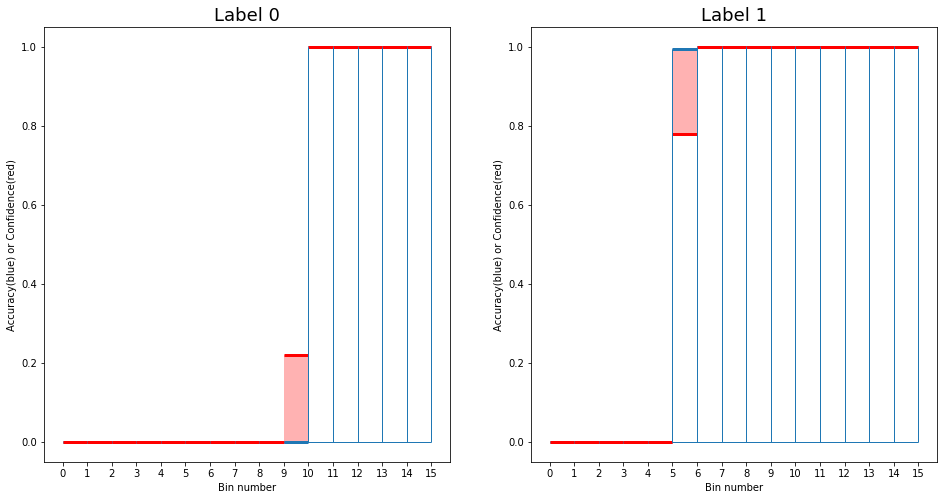

In [23]:
plot_reliability(proba_kdn, predicted_label_kdn, y_test.reshape(-1))


0.0031983357768464926

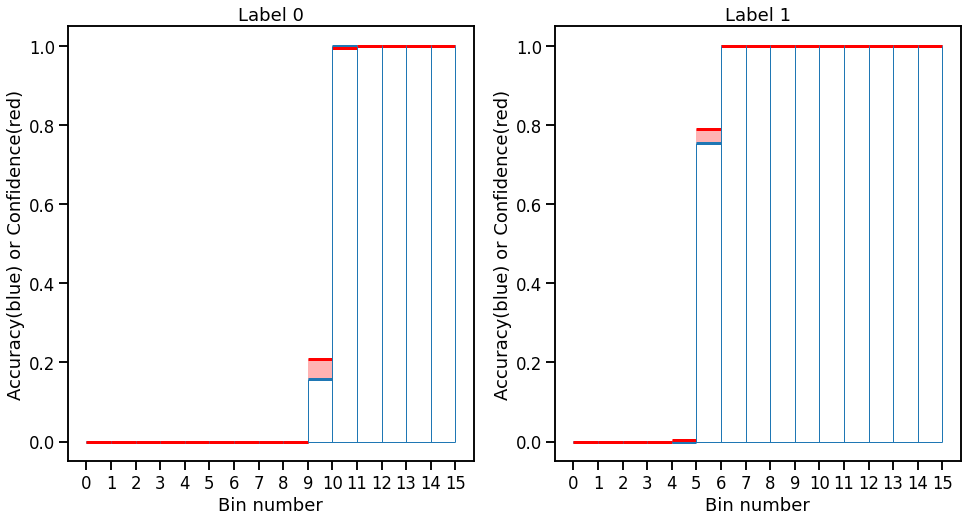

In [24]:
plot_reliability(proba_dn, np.argmax(proba_dn,axis=1), y_test.reshape(-1))

In [283]:
subtract_pixel_mean = True
normalize = False
(x_train, y_train), (x_test, y_test), trn_mean = get_data([0, 1])

In [190]:
subtract_pixel_mean = False
normalize = False
(x_train, y_train), (x_test, y_test), _= get_data([4, 5])

In [192]:
x_train -= trn_mean
x_test -= trn_mean

In [187]:
model_kdn.global_bias = -1e9

In [194]:
model_kdn.predict_proba(x_test[:10], distance='Geodesic')

array([[9.99999976e-01, 2.41545662e-08],
       [6.45148593e-08, 9.99999935e-01],
       [1.00000000e+00, 2.10395450e-11],
       [2.57673956e-11, 1.00000000e+00],
       [5.00000000e-01, 5.00000000e-01],
       [1.00000000e+00, 6.29252030e-11],
       [1.35782003e-07, 9.99999864e-01],
       [5.00000000e-01, 5.00000000e-01],
       [4.05898542e-12, 1.00000000e+00],
       [5.00000000e-01, 5.00000000e-01]])

In [165]:
y_test[1000:1030]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

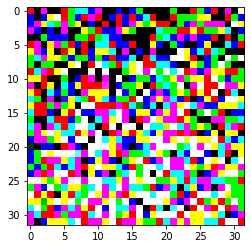

In [267]:
plt.imshow(x_test[:1].reshape(32,32,3))

In [268]:
model_kdn.network.predict(x_test[:30])

1/1 [==============================] - 0s 47ms/step


array([[3.2105488e-10, 1.0000000e+00],
       [3.2274530e-12, 1.0000000e+00],
       [3.5409059e-13, 1.0000000e+00],
       [4.4139972e-07, 9.9999952e-01],
       [7.7945799e-08, 9.9999988e-01],
       [6.1030828e-17, 1.0000000e+00],
       [1.5473361e-04, 9.9984533e-01],
       [1.3547129e-13, 1.0000000e+00],
       [2.5455230e-12, 1.0000000e+00],
       [6.5727107e-10, 1.0000000e+00],
       [7.5683461e-15, 1.0000000e+00],
       [5.4894003e-11, 1.0000000e+00],
       [1.5605254e-17, 1.0000000e+00],
       [9.4984554e-14, 1.0000000e+00],
       [5.8763060e-12, 1.0000000e+00],
       [4.9092180e-17, 1.0000000e+00],
       [3.4413424e-16, 1.0000000e+00],
       [3.3952689e-05, 9.9996603e-01],
       [2.7814373e-10, 1.0000000e+00],
       [1.3934039e-11, 1.0000000e+00],
       [2.3190382e-13, 1.0000000e+00],
       [1.7196068e-04, 9.9982804e-01],
       [1.9994607e-07, 9.9999976e-01],
       [5.3081855e-08, 1.0000000e+00],
       [5.0574023e-08, 1.0000000e+00],
       [5.4456089e-03, 9.

In [33]:
model_kdn.prior

{0: 0.3333333333333333, 1: 0.6666666666666666}

In [37]:
x_train.shape

(10000, 32, 32, 3)

In [101]:
model_kdn.polytope_cardinality[0]

[0.0,
 0.0,
 1.0000028813106665,
 1.0000026389836585,
 0.0,
 1.0000002221020483,
 0.0,
 0.0,
 0.0,
 1.0000069015441073,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0000246080072306,
 0.0,
 1.0000032818101126,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.000497682845267,
 1.0072050872415834,
 0.0,
 0.0,
 1.0030404470786458,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0000087489682852,
 0.0,
 0.0,
 1.0000132367144867,
 0.0,
 1.0000217299122096,
 1.000001708762132,
 1.0001005512753889,
 0.0,
 0.0,
 0.0,
 1.0001280548773221,
 1.0000319199447567,
 1.0000015895011312,
 0.0,
 0.0,
 1.000005969015782,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0034526722199753,
 0.0,
 1.0002640088791994,
 1.0000164818189676,
 0.0,
 1.0003692215533875,
 1.0000002222802566,
 0.0,
 0.0,
 0.0,
 1.0000027492178687,
 0.0,
 0.0,
 1.0025179709815375,
 0.0,
 0.0,
 0.0,
 1.0000002080665884,
 1.0009936051272692,
 1.0001361946966223,
 1.0001404472269926,
 1.0003732702449197,
 1.0000004859570717,
 0.0,
 0.0,
 1.0001064536287891,
 1.0001220486468352

In [97]:
model_kdn.polytope_cardinality[1]

[2.0000012691770084,
 2.0000312974482495,
 0.0,
 0.0,
 2.0000159122656616,
 0.0,
 2.0000063161448294,
 2.0000085515582,
 2.0000333750650685,
 0.0,
 2.0000028500521307,
 2.0000012171652397,
 2.000018812392672,
 2.0000012776035763,
 2.000034948892416,
 0.0,
 2.0000007551452117,
 0.0,
 2.001110601332014,
 2.000050881907028,
 2.000003629062608,
 2.000093464672618,
 2.00008958123303,
 2.0000012209099016,
 0.0,
 0.0,
 2.068173338701909,
 2.0000120977661777,
 0.0,
 2.001580756895478,
 2.000028331079736,
 2.0000012082507825,
 2.0000028128275185,
 2.000093791285859,
 0.0,
 2.0000099512723817,
 2.0000018553452956,
 0.0,
 2.000023097024576,
 0.0,
 0.0,
 0.0,
 2.0000167417769923,
 2.0108446031078877,
 2.000006319333199,
 0.0,
 0.0,
 0.0,
 2.000018856557009,
 2.000000414229603,
 0.0,
 2.000001182169073,
 2.0000074816894835,
 2.003599075175404,
 2.0000157303978083,
 2.0000172928484523,
 2.0000752149494985,
 2.000001992718333,
 0.0,
 2.0000171838931844,
 0.0,
 0.0,
 2.0000037042181917,
 0.0,
 0.0,
 2

In [160]:
with open('/Users/jayantadey/kdg/benchmarks/cifar10_experiments/kdn_models/cifar10_model_0_0.pickle', 'rb') as f:
            model_kdn = pickle.load(f)

EOFError: Ran out of input

In [104]:
(x_train_, y_train_), (x_test_, y_test_) = keras.datasets.cifar100.load_data()

In [107]:
x_test_ = x_test_.astype('float32') 

In [108]:
model_kdn.predict_proba(x_test_[:30], distance='Geodesic')

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [196]:
proba_kdn

{'Task 0': array([[9.99999776e-01, 2.23500088e-07],
        [1.00000000e+00, 1.18259938e-10],
        [9.99999832e-01, 1.68117272e-07],
        ...,
        [7.75822607e-06, 9.99992242e-01],
        [5.84862796e-08, 9.99999942e-01],
        [5.00000000e-01, 5.00000000e-01]])}

In [197]:
print('Task ', task_, ' MMC ', np.mean(np.max(proba_kdn['Task '+str(task_)], axis=1)))
print('Task ', task_, ' MMC ', np.mean(np.max(proba_dn['Task '+str(task_)], axis=1)))

Task  0  MMC  0.9732335520867337
Task  0  MMC  0.99316853
